In [1]:
import os, glob, time
import pandas as pd
import numpy as np

In [2]:
# here are the GoodVibes imports! 
import goodvibes.GoodVibes as gv
import goodvibes.thermo as thermo
import goodvibes.io as io
import goodvibes.pes as pes

In [3]:
# create a text file for all output (required)
log = io.Logger("Goodvibes", 'output', False)

In [4]:
os.chdir('goodvibes/examples')

### Example 1: Grimme-type quasi-harmonic correction with a (Grimme type) cut-off of 150 cm-1

In [5]:
options = gv.GVOptions()
options.QS = 'grimme' # this is the default and not required 
options.S_freq_cutoff = 150 # the default is 100

In [6]:
# Parse output file for energy, frequency, method, etc.
file = 'methylaniline.out'
file_data = io.getoutData(file, options)

In [7]:
# Carry out the thermochemical analysis
bbe_val = thermo.calc_bbe(file_data, options)

In [8]:
# Create pandas dataframe with thermochemical values
cols = ['scf_energy', 'zpe', 'enthalpy', 'entropy', 'qh_entropy', 'gibbs_free_energy', 'qh_gibbs_free_energy']
vals = [getattr(bbe_val, k) for k in cols]
bbe_df = pd.DataFrame(vals).T
bbe_df.columns = cols
bbe_df.insert(loc=0, column='Structure', value=[file_data.name])
bbe_df

,Structure,scf_energy,zpe,enthalpy,entropy,qh_entropy,gibbs_free_energy,qh_gibbs_free_energy
0,methylaniline.out,-326.664901,0.142118,-326.514489,0.000133,0.000132,-326.554157,-326.553954


### Example 2: Quasi-harmonic thermochemistry with a larger basis set single point energy correction link job

In [9]:
options = gv.GVOptions()
options.spc = 'link' # lets consider an internally-linked job where a single point energy follows a frequency calc.

In [10]:
# Parse output file for energy, frequency, method, etc.
file_data = io.getoutData('ethane_spc.out', options)

# Carry out the thermochemical analysis - auto-detect the vibrational scaling factor
options.freq_scale_factor = False # turns of default value of 1
level_of_theory = [file_data.functional + '/' + file_data.basis_set]
options.freq_scale_factor, options.mm_freq_scale_factor = gv.get_vib_scale_factor(level_of_theory, options, log)
bbe_val = thermo.calc_bbe(file_data, options)



o  Found vibrational scaling factor of 0.977 for B3LYP/6-31G(d) level of theory
   Alecu, I. M.; Zheng, J.; Zhao, Y.; Truhlar, D. G. J. Chem. Theory Comput. 2010, 6, 2872-2887.

In [11]:
# Create dataframe with thermochemical values
cols = ['sp_energy', 'scf_energy', 'zpe', 'enthalpy', 'entropy', 'qh_entropy', 'gibbs_free_energy', 'qh_gibbs_free_energy']
vals = [getattr(bbe_val, k) for k in cols]
bbe_df = pd.DataFrame(vals).T
bbe_df.columns = cols
bbe_df.insert(loc=0, column='Structure', value=[file_data.name])
bbe_df

,Structure,sp_energy,scf_energy,zpe,enthalpy,entropy,qh_entropy,gibbs_free_energy,qh_gibbs_free_energy
0,ethane_spc.out,-79.858399,-79.830421,0.073508,-79.780448,0.000092,0.000092,-79.808017,-79.808019


In [12]:
# now lets consider the case where the single point energy calculation is in a separate file
options.spc = 'TZ'
file = 'ethane.out'
file_data = io.getoutData(file, options)

In [13]:
# Create dataframe with thermochemical values
bbe_val = thermo.calc_bbe(file_data, options)
vals = [getattr(bbe_val, k) for k in cols]
bbe_df = pd.DataFrame(vals).T
bbe_df.columns = cols
bbe_df.insert(loc=0, column='Structure', value=[file_data.name])
bbe_df

,Structure,sp_energy,scf_energy,zpe,enthalpy,entropy,qh_entropy,gibbs_free_energy,qh_gibbs_free_energy
0,ethane.out,-79.858399,-79.830421,0.073508,-79.780448,0.000092,0.000092,-79.808017,-79.808019


### Example 3: Changing the temperature (from standard 298.15 K to 1000 K) and concentration (from standard state in gas phase, 1 atm, to standard state in solution, 1 mol/l)

In [14]:
options = gv.GVOptions()
options.conc = 1
options.temperature = 1000

In [15]:
# Parse output file for energy, frequency, method, etc.
file_data = io.getoutData('methylaniline.out', options)

# Carry out the thermochemical analysis and then create dataframe with results
bbe_val = thermo.calc_bbe(file_data, options)
cols = ['scf_energy', 'zpe', 'enthalpy', 'entropy', 'qh_entropy', 'gibbs_free_energy', 'qh_gibbs_free_energy']
bbe_df = pd.DataFrame([getattr(bbe_val, k) for k in cols]).T
bbe_df.columns = cols
bbe_df.insert(loc=0, column='Structure', value=[file_data.name])
bbe_df

,Structure,scf_energy,zpe,enthalpy,entropy,qh_entropy,gibbs_free_energy,qh_gibbs_free_energy
0,methylaniline.out,-326.664901,0.142118,-326.452307,0.000218,0.000217,-326.670519,-326.668866


### Example 5: Analyzing the Gibbs Energy using scaled vibrational frequencies

In [16]:
options = gv.GVOptions()
options.freq_scale_factor = 0.95

In [17]:
# Parse output file for energy, frequency, method, etc.
file_data = io.getoutData('methylaniline.out', options)

# Carry out the thermochemical analysis and then create dataframe with results
bbe_val = thermo.calc_bbe(file_data, options)
bbe_df = pd.DataFrame([getattr(bbe_val, k) for k in cols]).T
bbe_df.columns = cols
bbe_df.insert(loc=0, column='Structure', value=[file_data.name])
bbe_df

,Structure,scf_energy,zpe,enthalpy,entropy,qh_entropy,gibbs_free_energy,qh_gibbs_free_energy
0,methylaniline.out,-326.664901,0.135012,-326.521265,0.000135,0.000134,-326.561503,-326.561356


### Example 6: Writing Cartesian coordinates to file

In [18]:
options = gv.GVOptions()
files = set(glob.glob("HCN*.out")) # wildcard for file names

file_data = []
for file in files:
    file_data.append(io.getoutData(file, options))
    
# Write to .xyz and then .sdf formats
xyz = io.xyz_out("HCN_output.xyz", file_data)
sdf = io.sdf_out("HCN_output.sdf", file_data)

### Example 7: Analyzing multiple files at once

In [19]:
options = gv.GVOptions()
options.QS = 'grimme' # default setting (not required)
files = set(glob.glob("*.out")) - set(glob.glob("*NWChem.out"))

In [20]:
# Parse output files for energy, frequency, method, etc.
file_data = []
for file in files:
    file_data.append(io.getoutData(file, options))
        
# Carry out the thermochemical analysis
# the if statement here filters out structures for which thermochemical data is not available
bbe_vals = [thermo.calc_bbe(file, options) for file in file_data if hasattr(thermo.calc_bbe(file, options), 'zpe')]
names = [file.name for file in file_data if hasattr(thermo.calc_bbe(file, options), 'zpe')]

In [21]:
# Create dataframe with thermochemical values
vals = ['scf_energy', 'zpe', 'enthalpy', 'entropy', 'qh_entropy', 'gibbs_free_energy', 'qh_gibbs_free_energy']
bbe_df = pd.DataFrame([[getattr(i,k) for k in vals] for i in bbe_vals], columns = vals)
bbe_df.insert(loc=0, column='Structure', value=[file for file in names])
bbe_df

,Structure,scf_energy,zpe,enthalpy,entropy,qh_entropy,gibbs_free_energy,qh_gibbs_free_energy
0,Al_298K.out,-242.328708,0.000000,-242.326347,0.000059,0.000059,-242.344018,-242.344018
1,benzene.out,-232.227201,0.101377,-232.120521,0.000110,0.000110,-232.153263,-232.153265
2,isobutane.out,-158.458811,0.132380,-158.319804,0.000115,0.000115,-158.354046,-158.354056
3,HCN_singlet.out,-93.358851,0.015978,-93.339373,0.000077,0.000077,-93.362269,-93.362269
4,H2O.out,-76.368128,0.020772,-76.343577,0.000072,0.000072,-76.365035,-76.365035
5,allene.out,-116.569605,0.053913,-116.510916,0.000093,0.000093,-116.538534,-116.538537
6,Al_400K.out,-242.328708,0.000000,-242.326347,0.000059,0.000059,-242.344018,-242.344018
7,neopentane.out,-197.772980,0.160311,-197.604824,0.000124,0.000124,-197.641776,-197.641791
8,HCN_triplet.out,-93.153787,0.012567,-93.137780,0.000081,0.000081,-93.161850,-93.161850
9,CuCN.out,-289.005463,0.006594,-288.994307,0.000087,0.000087,-289.020260,-289.020264


In [22]:
# Total CPU time
thermo_data = dict(zip(files, bbe_vals))
cpu = gv.calc_cpu(thermo_data, options, log)

   TOTAL CPU      0 days  2 hrs 37 mins  5 secs


### Example 8: Entropic Symmetry Correction

In [23]:
options = gv.GVOptions()
options.QS = 'grimme'
files = ["allene.out", "benzene.out", "ethane.out", "isobutane.out", "neopentane.out"]

# Parse output files for energy, frequency, method, etc.
file_data = []
for file in files:
    file_data.append(io.getoutData(file, options))
    
# Carry out the thermochemical analysis
bbe_vals = [thermo.calc_bbe(file, options) for file in file_data]

In [24]:
# Create dataframe with thermochemical values
# These point groups are parsed from the Gaussian log files 
vals = ['scf_energy', 'zpe', 'enthalpy', 'entropy', 'qh_entropy', 'gibbs_free_energy', 'qh_gibbs_free_energy', 'point_group']
bbe_df = pd.DataFrame([[getattr(i,k) for k in vals] for i in bbe_vals], columns = vals)
bbe_df.insert(loc=0, column='Structure', value=[file.name for file in file_data])
bbe_df

,Structure,scf_energy,zpe,enthalpy,entropy,qh_entropy,gibbs_free_energy,qh_gibbs_free_energy,point_group
0,allene.out,-116.569605,0.053913,-116.510916,0.000093,0.000093,-116.538534,-116.538537,D2D
1,benzene.out,-232.227201,0.101377,-232.120521,0.000110,0.000110,-232.153263,-232.153265,C1
2,ethane.out,-79.830421,0.075238,-79.750770,0.000092,0.000092,-79.778293,-79.778295,C1
3,isobutane.out,-158.458811,0.132380,-158.319804,0.000115,0.000115,-158.354046,-158.354056,C1
4,neopentane.out,-197.772980,0.160311,-197.604824,0.000124,0.000124,-197.641776,-197.641791,C1


In [25]:
# Several of these molecules were assigned as C1 by Gaussian. 
# But we can try to obtain the point groups independently and then recompute the partition functions
options.ssymm = True
file_data = []
for file in files:
    file_data.append(io.getoutData(file, options))
    
# Carry out the thermochemical analysis again
bbe_vals = [thermo.calc_bbe(file, options) for file in file_data]
# Show a table
vals = ['scf_energy', 'zpe', 'enthalpy', 'entropy', 'qh_entropy', 'gibbs_free_energy', 'qh_gibbs_free_energy', 'point_group']
bbe_df = pd.DataFrame([[getattr(i,k) for k in vals] for i in bbe_vals], columns = vals)
bbe_df.insert(loc=0, column='Structure', value=[file.name for file in file_data])
bbe_df

,Structure,scf_energy,zpe,enthalpy,entropy,qh_entropy,gibbs_free_energy,qh_gibbs_free_energy,point_group
0,allene.out,-116.569605,0.053913,-116.510916,0.000088,0.000088,-116.537225,-116.537228,D2d
1,benzene.out,-232.227201,0.101377,-232.120521,0.000102,0.000102,-232.150917,-232.150919,D6h
2,ethane.out,-79.830421,0.075238,-79.750770,0.000087,0.000087,-79.776601,-79.776603,D3d
3,isobutane.out,-158.458811,0.132380,-158.319804,0.000111,0.000111,-158.353008,-158.353019,C3v
4,neopentane.out,-197.772980,0.160311,-197.604824,0.000116,0.000116,-197.639430,-197.639444,Td


### Example 9: Potential Energy Surface (PES) Comparison with Accessible Conformer Correction

In [26]:
os.chdir('gconf_ee_boltz')

In [27]:
files = set(glob.glob("*.log"))
options = gv.GVOptions()
options.pes = 'gconf_aminox_cat.yaml' # external file defining PES
options.gconf = False
# parse file data
file_data = []
for file in files:
    file_data.append(io.getoutData(file, options))

# thermochemical calculation
bbe_vals = [thermo.calc_bbe(file, options) for file in file_data]
thermo_data = dict(zip(files, bbe_vals))

# Show a table
vals = ['scf_energy', 'zpe', 'enthalpy', 'entropy', 'qh_entropy', 'gibbs_free_energy', 'qh_gibbs_free_energy']
bbe_df = pd.DataFrame([[getattr(i,k) for k in vals] for i in bbe_vals], columns = vals)
bbe_df.insert(loc=0, column='Structure', value=[file.name for file in file_data])
bbe_df

,Structure,scf_energy,zpe,enthalpy,entropy,qh_entropy,gibbs_free_energy,qh_gibbs_free_energy
0,aminox_cat_conf65_S.log,-517.877161,0.206999,-517.658210,0.000165,0.000162,-517.707487,-517.706389
1,Aminoxylation_TS2_S.log,-879.404445,0.304434,-879.081872,0.000213,0.000205,-879.145351,-879.142947
2,aminox_cat_conf280_R.log,-517.877308,0.207081,-517.658218,0.000166,0.000162,-517.707700,-517.706518
3,Aminoxylation_TS1_R.log,-879.405138,0.304487,-879.082686,0.000211,0.000203,-879.145547,-879.143350
4,aminox_cat_conf212_S.log,-517.875165,0.206534,-517.656256,0.000172,0.000165,-517.707550,-517.705591
5,aminox_subs_conf713.log,-361.535757,0.098285,-361.430368,0.000126,0.000126,-361.467939,-361.467818


In [28]:
# Convert absolute values into a relatve PES 
species, table = pes.tabulate(thermo_data, options, log)
# Create a dataframe of the PES
pes_df = pd.DataFrame(table)
pes_df.columns = ["DE", "DZPE", "DH", "T.DS", "T.qh-DS", "DG(T)", "qh-DG(T)"]
pes_df.insert(loc=0, column='Species', value=species[0])
pes_df.head()

,Species,DE,DZPE,DH,T.DS,T.qh-DS,DG(T),qh-DG(T)
0,cat+subs,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
1,TS,4.714252,-0.474654,3.495076,-15.320358,-15.820644,18.815434,19.31572



   Graphing Reaction Profile


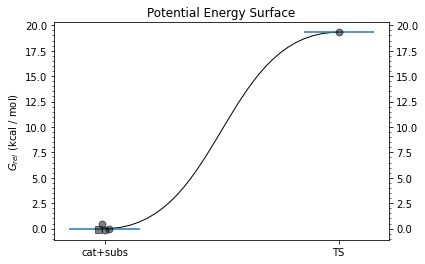

In [29]:
# Plot the PES
options.graph = options.pes
graph_data = pes.get_pes(thermo_data, options, log)
pes.graph_reaction_profile(graph_data, options, log)

### Example 10: Stereoselectivity and Boltzmann populations

In [30]:
options = gv.GVOptions()
options.QS = 'grimme'
options.Boltz = True

# Define two groups of files by wildcard matching
options.ee = "*_R*:*_S*"
files = set(glob.glob("Aminoxylation_TS*.log"))

In [31]:
file_data = []
for file in files:
    file_data.append(io.getoutData(file, options))


In [32]:
bbe_vals = [thermo.calc_bbe(file, options) for file in file_data]
thermo_data = dict(zip(files, bbe_vals))

boltz_facs, weighted_free_energy, boltz_sum = gv.get_boltz(thermo_data, options)
ee, er, ratio, dd_free_energy, failed, preference = gv.get_selectivity(files, options, boltz_facs, boltz_sum, log)



   Selectivity                                Excess (%)     Ratio (%)         Ratio         Major  DDG kcal/mol
   *************************************************************************************************************
o                                                  21.00         61:39         1.5:1             R          0.25
   *************************************************************************************************************
